In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import glob, os
import numpy as np
from comet_ml import Experiment, Optimizer
import pickle
import logging
import sys
from sklearn.utils import class_weight

In [2]:
os.environ['TF_KERAS'] = '1'
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Lambda, BatchNormalization, TimeDistributed, \
    CuDNNLSTM, Bidirectional, Input, concatenate, Flatten, RepeatVector, Activation, Multiply, Permute, Masking
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model, Sequence

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import tensorflow as tf

/usr/local/tensorflow/python3.5/1.13.1/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/tensorflow/python3.5/1.13.1/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/tensorflow/python3.5/1.13.1/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/tensorflow/python3.5/1.

In [3]:
tf.test.is_gpu_available()

True

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# only reserve 1 GPU

In [5]:
# tf.enable_eager_execution()
my_seed = 1234
tf.set_random_seed(my_seed)

In [6]:
logger = logging.getLogger('training')
logger.addHandler(logging.StreamHandler(sys.stdout))
logger.setLevel(logging.DEBUG)

# Read data

In [7]:
def read_subject_writings(subject_file):
    writings = []
    with open(subject_file) as sf:
        contents = sf.read()
        root = ET.fromstring(contents)
        try:
            subject = root.findall('ID')[0].text.strip()
        except Exception:
            print('Cannot extract ID', contents[:500], '\n-------\n')        
        for w in root.iter('WRITING'):
            subject_writings = {'subject': subject}
            for title in w.findall('TITLE'):
                subject_writings['title'] = title.text
            for text in w.findall('TEXT'):
                subject_writings['text'] = text.text
            for date in w.findall('DATE'):
                subject_writings['date'] = date.text
            writings.append(subject_writings)
    return writings

In [8]:
root_dir = '/home/anasab/' 
# root_dir = '/home/ana/'

### eRisk 2020 T1

In [9]:
datadir_T1 = root_dir + '/eRisk/data/eRisk2020_T1_train/eRISK2020_T1_training_data/eRISK2020_training_data/data/'
labels_file_T1 = root_dir + '/eRisk/data//eRisk2020_T1_train/eRISK2020_T1_training_data/eRISK2020_training_data/golden_truth.txt'

In [10]:
def read_texts_2020(datadir_T1, labels_file_T1):
    writings = []
    for subject_file in os.listdir(datadir_T1):
        print(subject_file)
        writings.extend(read_subject_writings(os.path.join(datadir_T1, subject_file)))
    writings_df = pd.DataFrame(writings)

    labels_T1 = pd.read_csv(labels_file_T1, delimiter=' ', names=['subject', 'label'])
    labels_T1 = labels_T1.set_index('subject')

    writings_df['label'] = writings_df['subject'].apply(
    lambda s: labels_T1.loc[s, 'label'])
    
    return writings_df



### eRisk 2019 T1 (Anorexia)

In [11]:
datadirs_T1_2019 = {
    'train': ['2018 test/', '2018 train/positive_examples/', '2018 train/negative_examples/'],
    'test': ['data/']
}
datadir_root_T1_2019 = {
    'train': root_dir + '/eRisk/data/past/eRisk2019_T1/training data - t1/',
    'test': root_dir + '/eRisk/data/past/eRisk2019_T1/test data - T1/'
}
    
labels_files_T1_2019 = {
    'train': ['2018 train/risk_golden_truth.txt', '2018 test/risk-golden-truth-test.txt'],
    'test': ['T1_erisk_golden_truth.txt']
}

In [12]:
def read_texts_2019(datadir_root_T1_2019,
                   datadirs_T1_2019,
                   labels_files_T1_2019,
                   test_suffix='0000'):
    writings = {'train': [], 'test': []}
    writings_df = pd.DataFrame()
    labels_df = pd.DataFrame()

    for subset in ('train', 'test'):
        for subdir in [os.path.join(datadir_root_T1_2019[subset], subp) for subp in datadirs_T1_2019[subset]]:
            if subset=='train':
                chunkdirs = [os.path.join(datadir_root_T1_2019[subset], subdir, chunkdir) 
                             for chunkdir in os.listdir(subdir)]
            else:
                chunkdirs = [os.path.join(datadir_root_T1_2019[subset], subdir)]
                
            for chunkdir in chunkdirs:
                if not os.path.isdir(chunkdir):
                    continue
                for subject_file in os.listdir(chunkdir):
                    writings[subset].extend(read_subject_writings(os.path.join(chunkdir, subject_file)))
        writings_df_part = pd.DataFrame(writings[subset])
        # add a suffix for users in the test -- the numbers are duplicated with the ones in train
        if subset=='test':
            writings_df_part['subject'] = writings_df_part['subject'].apply(lambda s: s+test_suffix)
            print(subset, writings_df_part.subject)
        writings_df_part['subset'] = subset
        writings_df = pd.concat([writings_df, writings_df_part])
        writings_df.reindex()

        for label_file in labels_files_T1_2019[subset]:
            labels = pd.read_csv(os.path.join(datadir_root_T1_2019[subset], label_file), 
                                 delimiter='\s+', names=['subject', 'label'])
            # add a suffix for users in the test -- the numbers are duplicated with the ones in train
            if subset=='test':
                labels['subject'] = labels['subject'].apply(lambda s: s+test_suffix)
            labels_df = pd.concat([labels_df, labels])
    labels_df = labels_df.drop_duplicates()
    labels_df = labels_df.set_index('subject')

    writings_df = writings_df.drop_duplicates()
    
    writings_df = writings_df.join(labels_df, on='subject')
    
    return writings_df

## Preprocess text

In [13]:
# writings_df = read_texts_2020(datadir_T1, labels_file_T1)
# writings_df = read_texts_2019(datadir_root_T1_2019,
#                    datadirs_T1_2019,
#                    labels_files_T1_2019)
writings_df = pickle.load(open('writings_df_selfharm_liwc', 'rb'))

In [14]:
writings_df.label.hist()

In [15]:
writings_df.head()

,subject,title,date,text,label,tokenized_title,title_len,tokenized_text,text_len,all_tokens,...,feel,excl,future,nonfl,ppron,shehe,i,we,you,they
0,subject8292,If anyone could help with which sub to put thi...,2016-08-02 09:22:12,NaN,0,"[if, anyone, could, help, with, which, sub, to...",11.0,None,NaN,"[if, anyone, could, help, with, which, sub, to...",...,0.0,0.090909,0.090909,0.0,0.000000,0.00000,0.000000,0.00000,0.0,0.0
1,subject8292,I'm literally never gonna stop waiting...,2016-08-05 09:35:55,NaN,0,"[i, m, literally, never, gonna, stop, waiting]",7.0,None,NaN,"[i, m, literally, never, gonna, stop, waiting]",...,0.0,0.000000,0.285714,0.0,0.142857,0.00000,0.142857,0.00000,0.0,0.0
2,subject8292,This is a really interesting study! Makes sens...,2016-08-05 21:36:24,NaN,0,"[this, is, a, really, interesting, study, make...",9.0,None,NaN,"[this, is, a, really, interesting, study, make...",...,0.0,0.111111,0.000000,0.0,0.000000,0.00000,0.000000,0.00000,0.0,0.0
3,subject8292,The only thing Frank is building ...,2016-08-07 23:35:23,"... Is hype. Think about it, every time he wor...",0,"[the, only, thing, frank, is, building]",6.0,"[is, hype, think, about, it, every, time, he, ...",26.0,"[is, hype, think, about, it, every, time, he, ...",...,0.0,0.000000,0.062500,0.0,0.062500,0.03125,0.000000,0.03125,0.0,0.0
4,subject8292,Mostly always me during this whole charade,2016-08-09 08:39:41,NaN,0,"[mostly, always, me, during, this, whole, char...",7.0,None,NaN,"[mostly, always, me, during, this, whole, char...",...,0.0,0.000000,0.000000,0.0,0.142857,0.00000,0.142857,0.00000,0.0,0.0


In [16]:
tokenizer = RegexpTokenizer(r'\w+')

def tokenize(t):
    return tokenizer.tokenize(t.lower())

In [17]:
def tokenize_fields(writings_df):
    writings_df['tokenized_title'] = writings_df['title'].apply(lambda t: tokenize(t) 
                                                                if type(t)==str and t else None)
    writings_df['title_len'] = writings_df['tokenized_title'].apply(lambda t: len(t) 
                                                                    if type(t)==list and t else None)
    writings_df['tokenized_text'] = writings_df['text'].apply(lambda t: tokenize(t) 
                                                              if type(t)==str and t else None)
    writings_df['text_len'] = writings_df['tokenized_text'].apply(lambda t: len(t) 
                                                                  if type(t)==list and t else None)
    return writings_df

In [18]:
writings_df.text_len.describe()

count    127941.000000
mean         32.268929
std          82.590713
min           0.000000
25%           6.000000
50%          13.000000
75%          31.000000
max        7201.000000
Name: text_len, dtype: float64

In [19]:
writings_df.title_len.describe()

count    49762.000000
mean        10.699771
std          9.282454
min          0.000000
25%          4.000000
50%          8.000000
75%         14.000000
max        149.000000
Name: title_len, dtype: float64

In [20]:
writings_df.groupby('subject').mean().describe()

,label,title_len,text_len,funct,article,affect,negemo,sad,cogmech,inhib,...,feel,excl,future,nonfl,ppron,shehe,i,we,you,they
count,340.000000,336.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,...,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000
mean,0.120588,9.514427,33.122855,0.425434,0.049284,0.080990,0.023242,0.003515,0.125608,0.004730,...,0.005483,0.022510,0.089113,0.002740,0.079820,0.008573,0.040263,0.004642,0.020469,0.005873
std,0.326128,4.714271,31.874155,0.085804,0.013413,0.032889,0.011015,0.002891,0.031706,0.002874,...,0.004131,0.009740,0.028436,0.004729,0.027475,0.007100,0.020218,0.004367,0.012310,0.004040
min,0.000000,1.000000,1.000000,0.018182,0.005237,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.601190,14.402079,0.379003,0.042321,0.063090,0.016110,0.001949,0.109709,0.002829,...,0.003234,0.016795,0.073775,0.000669,0.064952,0.004052,0.027496,0.002302,0.013474,0.003566
50%,0.000000,8.660264,24.212121,0.439643,0.049415,0.074207,0.022189,0.002867,0.127451,0.004594,...,0.004879,0.022203,0.088307,0.001581,0.077149,0.006945,0.037420,0.003735,0.018725,0.005123
75%,0.000000,11.526931,37.878342,0.478550,0.057188,0.090063,0.028348,0.004319,0.145710,0.006224,...,0.006712,0.027300,0.105534,0.002902,0.093965,0.011430,0.049840,0.005544,0.025045,0.007488
max,1.000000,32.166667,266.446446,0.646948,0.095561,0.270520,0.073699,0.020833,0.251136,0.022180,...,0.042094,0.090475,0.202499,0.045799,0.213871,0.069447,0.133143,0.037712,0.099026,0.041093


In [21]:
writings_df.groupby('subject').max().groupby('label').count()

,date,title_len,text_len,all_tokens,funct,article,affect,negemo,sad,cogmech,...,feel,excl,future,nonfl,ppron,shehe,i,we,you,they
label,,,,,,,,,,,,,,,,,,,,,
0,299,296,299,299,299,299,299,299,299,299,...,299,299,299,299,299,299,299,299,299,299
1,41,40,41,41,41,41,41,41,41,41,...,41,41,41,41,41,41,41,41,41,41


In [22]:
print("Average number of posts per user", writings_df.groupby('subject').count().title.mean())
print("Average number of comments per user", writings_df.groupby('subject').count().text.mean())


Average number of posts per user 146.35882352941175
Average number of comments per user 376.2970588235294


In [23]:
writings_df.groupby('subject').count().title.describe()

count    340.000000
mean     146.358824
std      240.998992
min        0.000000
25%       13.000000
50%       42.500000
75%      148.500000
max      998.000000
Name: title, dtype: float64

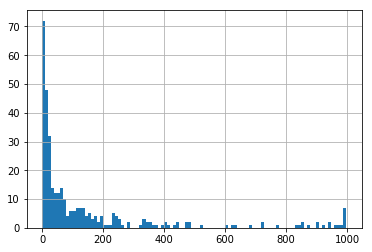

In [24]:
writings_df.groupby('subject').count().title.hist(bins=100)

In [25]:
writings_df.groupby('subject').count().text.describe()

count     340.000000
mean      376.297059
std       379.091730
min         1.000000
25%        54.000000
50%       214.500000
75%       646.000000
max      1350.000000
Name: text, dtype: float64

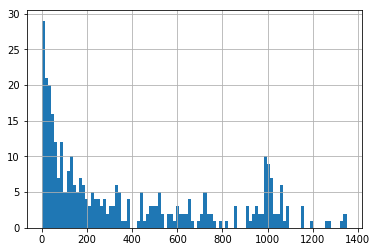

In [26]:
writings_df.groupby('subject').count().text.hist(bins=100)

In [27]:
writings_df.groupby('subject').count().all_tokens.describe()

count     340.000000
mean      502.052941
std       532.656738
min         8.000000
25%        69.750000
50%       282.000000
75%       806.500000
max      1992.000000
Name: all_tokens, dtype: float64

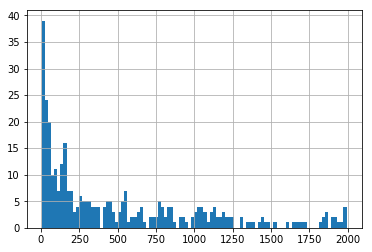

In [28]:
writings_df.groupby('subject').count().all_tokens.hist(bins=100)

# Recurrent NN

## Extract features and encode data

In [66]:
hyperparams_features = {
    "max_features": 20000,
    # cut texts after this number of words
    # (among top max_features most common words)
    "maxlen": 50,
    "embedding_dim": 300,
    "user_level": True,
    "posts_per_user": 100,
    "batch_size": 10,
}


### Emotions

In [67]:
def load_NRC(nrc_path):
    word_emotions = {}
    emotion_words = {}
    with open(nrc_path) as in_f:
        for line in in_f:
            line = line.strip()
            if not line:
                continue
            word, emotion, label = line.split()
            if word not in word_emotions:
                word_emotions[word] = set()
            if emotion not in emotion_words:
                emotion_words[emotion] = set()
            label = int(label)
            if label:
                word_emotions[word].add(emotion)
                emotion_words[emotion].add(word)
    return emotion_words

nrc_lexicon_path = root_dir + '/resources/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
nrc_lexicon = load_NRC(nrc_lexicon_path)
emotions = list(nrc_lexicon.keys())


In [68]:
def encode_emotions(tokens, emotion_lexicon, emotions, relative=True):
    text_len = len(tokens)
    encoded_emotions = [0 for e in emotions]
    for i, emotion in enumerate(emotions):
        try:
            emotion_words = [t for t in tokens if t in emotion_lexicon[emotion]]
            if relative:
                encoded_emotions[i] = len(emotion_words) / len(tokens)
            else:
                encoded_emotions[i] = len(emotion_words)
        except ValueError:
            print("Emotion not found.")
    return encoded_emotions

In [69]:
from liwc_readDict import readDict

liwc = readDict(root_dir + '/resources/liwc.dic')

categories = set([c for (w,c) in liwc])
len(categories)

64

### Style features

#### Char n-grams

In [70]:
def extract_ngrams(tokens):
    pass

#### Personal pronouns

In [71]:
first_person_pronouns = {"i", "me", "my", "mine", "myself"}
def encode_pronouns(tokens, pronouns={"i", "me", "my", "mine", "myself"}, relative=True):
    if not tokens:
        return np.nan
    text_len = len(tokens)
    nr_pronouns = len([t for t in tokens if t in pronouns])
    if relative:
        return nr_pronouns/text_len
    else:
        return nr_pronouns

#### Stopwords

In [72]:
stopword_list = stopwords.words("english")
def encode_stopwords(tokens, stopwords=stopword_list):
    encoded_stopwords = [0 for s in stopword_list]
    if not tokens:
        return encoded_stopwords
    for i, stopword in enumerate(stopwords):
        if stopword in tokens:
            encoded_stopwords[i] += 1
    return encoded_stopwords

### Topics

### Encode data

In [73]:
from collections import Counter
def load_erisk_data(writings_df, voc_size, emotion_lexicon, seq_len, emotions =  
                    ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
                     'negative', 'positive', 'sadness', 'surprise', 'trust'],
                    liwc_categories = categories,
                    pronouns = ["i", "me", "my", "mine", "myself"],
                    train_prop=0.7, valid_prop=0.3, test_slice=2,
                    nr_slices=5,
                    min_post_len=3, min_word_len=1, 
                    user_level=True, vocabulary=None,
                   logger=logger):
    logger.debug("Loading data...\n")
    if not vocabulary:
        vocabulary = {}
        word_freqs = Counter()
        for words in writings_df.tokenized_text:
            word_freqs.update(words)
        for words in writings_df.tokenized_title:
            word_freqs.update(words)
        i = 1
        for w, f in word_freqs.most_common(voc_size-2): # keeping voc_size-1 for unk
            if len(w) < min_word_len:
                continue
            vocabulary[w] = i
            i += 1
    tokens_data_train = []
    categ_data_train = []
    sparse_data_train = []
    tokens_data_valid = []
    categ_data_valid = []
    sparse_data_valid = []
    tokens_data_test = []
    categ_data_test = []
    sparse_data_test = []
    labels_train = []
    users_train = []
    labels_valid = []
    users_valid = []
    users_test = []
    labels_test = []
    if 'subset' in writings_df.columns:
        training_subjects = list(set(writings_df[writings_df['subset']=='train'].subject))
        test_subjects = list(set(writings_df[writings_df['subset']=='test'].subject))
    else:
        all_subjects = sorted(list(set(writings_df.subject)))
        training_subjects_size = int(len(all_subjects) * train_prop)
        test_subjects_size = len(all_subjects) - training_subjects_size
        # Cross-validation, with fixed slice as input
        test_prop = 1-train_prop
        test_slice = min(test_slice, nr_slices)
        logger.debug("start index: %f, from %f\n" % (
            len(all_subjects)*(1/nr_slices)*test_slice, test_prop*test_slice))
        start_slice = int(len(all_subjects)*(1/nr_slices)*test_slice)
        test_subjects = all_subjects[start_slice: start_slice+test_subjects_size]
        training_subjects = [s for s in all_subjects if s not in test_subjects]
    training_subjects = sorted(training_subjects) # ensuring reproducibility
    valid_subjects_size = int(len(training_subjects) * valid_prop)
    valid_subjects = training_subjects[:valid_subjects_size]
    training_subjects = training_subjects[valid_subjects_size:]
    categories = [c for c in liwc_categories if c in writings_df.columns]
    logger.debug("%d training users, %d validation users, %d test users." % (
        len(training_subjects), 
          len(valid_subjects),
          len(test_subjects)))
    subjects_split = {'train': training_subjects, 
                      'valid': valid_subjects, 
                      'test': test_subjects}

    user_level_texts = {}
    for row in writings_df.sort_values(by='date').itertuples():
        words = []
        if row.tokenized_title:
            words.extend(row.tokenized_title)
        if row.tokenized_text:
            words.extend(row.tokenized_text)
        if not words or len(words)<min_post_len:
            print(row.subject)
            continue
        label = row.label
        liwc_categs = [getattr(row, categ) for categ in categories]
        if row.subject not in user_level_texts.keys():
            user_level_texts[row.subject] = {}
            user_level_texts[row.subject]['texts'] = [words]
            user_level_texts[row.subject]['label'] = label
            user_level_texts[row.subject]['liwc'] = [liwc_categs]
        else:
            user_level_texts[row.subject]['texts'].append(words)
            user_level_texts[row.subject]['liwc'].append(liwc_categs)
    return user_level_texts, subjects_split, vocabulary


In [74]:
user_level_data, subjects_split, vocabulary = load_erisk_data(writings_df, 
                                                            seq_len=hyperparams_features['maxlen'],
                                                            voc_size=hyperparams_features['max_features'],
                                                           emotion_lexicon=nrc_lexicon,
                                                           emotions=emotions,
                                                           user_level=hyperparams_features['user_level'],
                                                                                logger=logger
#                                                            vocabulary=pickle.load(open('vocabulary20K_selfharm.pkl', 'rb'))
                                                                               )

Loading data...



DEBUG:training:Loading data...



start index: 136.000000, from 0.600000



DEBUG:training:start index: 136.000000, from 0.600000



166 training users, 71 validation users, 103 test users.


DEBUG:training:166 training users, 71 validation users, 103 test users.


subject1623
subject8978
subject1623
subject1914
subject1914
subject8978
subject2947
subject2495
subject1914
subject8001
subject2495
subject6013
subject6013
subject6013
subject8001
subject2495
subject1914
subject2495
subject8472
subject8472
subject3881
subject1623
subject8472
subject8472
subject8978
subject6035
subject6035
subject8001
subject2947
subject8472
subject8472
subject3881
subject5000
subject3881
subject3881
subject814
subject814
subject814
subject814
subject814
subject814
subject814
subject814
subject814
subject203
subject6035
subject6035
subject6035
subject814
subject814
subject814
subject814
subject814
subject814
subject814
subject814
subject814
subject814
subject814
subject814
subject814
subject814
subject814
subject814
subject814
subject203
subject814
subject814
subject814
subject814
subject814
subject814
subject814
subject203
subject814
subject814
subject814
subject814
subject203
subject203
subject5000
subject5000
subject814
subject203
subject814
subject203
subject203
sub

subject2621
subject2547
subject5699
subject1748
subject6013
subject6013
subject6013
subject6013
subject1728
subject814
subject1748
subject1728
subject1748
subject1728
subject1728
subject1728
subject6013
subject8472
subject1914
subject6013
subject5908
subject8657
subject1748
subject47
subject8472
subject5699
subject8657
subject8657
subject8657
subject8472
subject1914
subject814
subject6670
subject6428
subject5699
subject5908
subject6013
subject5036
subject5908
subject1885
subject8472
subject511
subject8657
subject5908
subject814
subject8657
subject8657
subject8657
subject8657
subject8657
subject8657
subject8657
subject8657
subject8657
subject8657
subject8657
subject8657
subject8657
subject8657
subject8657
subject8657
subject8657
subject8657
subject8657
subject8657
subject8657
subject8978
subject8472
subject8978
subject8657
subject8657
subject2948
subject814
subject5036
subject2547
subject4247
subject2547
subject8472
subject1748
subject3868
subject3868
subject8472
subject8472
subject8472

subject4247
subject4002
subject8472
subject2495
subject5140
subject1485
subject4459
subject4459
subject8472
subject9725
subject6013
subject5699
subject5699
subject8657
subject8064
subject8064
subject6013
subject5140
subject6013
subject5036
subject5036
subject6035
subject814
subject5840
subject1748
subject4414
subject4414
subject4414
subject4414
subject4414
subject5036
subject5036
subject5036
subject5036
subject5036
subject2605
subject4414
subject4414
subject4414
subject2605
subject2605
subject8657
subject2605
subject4414
subject4414
subject4414
subject4414
subject6146
subject6146
subject9114
subject682
subject2605
subject6146
subject6146
subject6146
subject6013
subject1728
subject2605
subject1728
subject1728
subject1728
subject7898
subject2605
subject203
subject7435
subject203
subject2605
subject2948
subject4247
subject8472
subject7435
subject3181
subject4247
subject5979
subject1885
subject8472
subject8472
subject7435
subject2605
subject2605
subject2605
subject2605
subject8472
subject2

subject1105
subject8472
subject1105
subject1793
subject1793
subject1105
subject1105
subject5036
subject203
subject8657
subject5036
subject4526
subject8657
subject7857
subject8657
subject5699
subject6146
subject1210
subject5409
subject203
subject814
subject1105
subject1105
subject1105
subject4459
subject4074
subject5409
subject5409
subject4074
subject4074
subject1485
subject203
subject5409
subject5793
subject6518
subject6518
subject8472
subject8200
subject1210
subject8472
subject5908
subject4831
subject1105
subject733
subject2495
subject6786
subject1793
subject501
subject8200
subject9725
subject4459
subject2495
subject1793
subject8472
subject7262
subject4831
subject2495
subject8472
subject4831
subject5699
subject5699
subject4414
subject4414
subject4414
subject8472
subject4414
subject5282
subject8472
subject5908
subject5908
subject8200
subject4196
subject4831
subject4831
subject4831
subject4831
subject5793
subject4831
subject4831
subject4831
subject4831
subject4831
subject4414
subject441

subject6013
subject814
subject641
subject4719
subject3191
subject7857
subject641
subject5840
subject7318
subject9725
subject6013
subject6013
subject0
subject641
subject641
subject3191
subject641
subject641
subject641
subject7318
subject1748
subject3191
subject3191
subject4071
subject3178
subject3178
subject6013
subject6013
subject4071
subject6035
subject682
subject2446
subject641
subject3191
subject3191
subject641
subject641
subject641
subject5979
subject641
subject3191
subject5409
subject641
subject6786
subject8472
subject641
subject9725
subject641
subject7318
subject7318
subject641
subject641
subject641
subject641
subject641
subject2605
subject6786
subject641
subject641
subject641
subject379
subject379
subject641
subject8978
subject5840
subject7698
subject379
subject641
subject4071
subject379
subject7318
subject379
subject641
subject4198
subject7318
subject7318
subject1093
subject1093
subject7318
subject1093
subject4333
subject6013
subject1485
subject203
subject6013
subject6833
subje

subject7318
subject7318
subject5409
subject203
subject8472
subject4074
subject6930
subject7439
subject4762
subject7318
subject7318
subject974
subject379
subject379
subject4071
subject4071
subject4071
subject4071
subject7318
subject379
subject8726
subject7318
subject5036
subject4071
subject6428
subject4071
subject7857
subject5036
subject6428
subject974
subject5036
subject7627
subject4526
subject6013
subject6013
subject6013
subject7318
subject7318
subject7318
subject4071
subject1210
subject203
subject203
subject2547
subject6428
subject6428
subject4762
subject733
subject4762
subject6786
subject203
subject6786
subject4934
subject4934
subject0
subject7627
subject6013
subject9114
subject5878
subject4762
subject379
subject379
subject379
subject379
subject5148
subject1793
subject5409
subject5148
subject379
subject2605
subject4510
subject4510
subject4071
subject379
subject8472
subject2097
subject6035
subject2446
subject5793
subject7692
subject9725
subject6428
subject814
subject379
subject379
su

subject203
subject2446
subject6428
subject7857
subject5878
subject511
subject2690
subject6035
subject5036
subject5036
subject5036
subject9114
subject2446
subject3191
subject5878
subject8726
subject8726
subject5995
subject2690
subject2446
subject7229
subject7229
subject2446
subject3178
subject7229
subject7229
subject7229
subject7229
subject6670
subject2690
subject5383
subject7229
subject6428
subject4762
subject1210
subject8472
subject3178
subject6930
subject6930
subject8329
subject4526
subject9725
subject2690
subject8657
subject8657
subject8721
subject8329
subject5409
subject4333
subject1793
subject1793
subject1793
subject5282
subject8472
subject8472
subject1793
subject8726
subject814
subject2690
subject6352
subject6035
subject6352
subject2690
subject8361
subject8361
subject2446
subject7439
subject269
subject5833
subject6866
subject814
subject4526
subject8472
subject8472
subject5833
subject8726
subject5409
subject1793
subject2446
subject6866
subject1793
subject9725
subject6035
subject26

subject2690
subject3994
subject4278
subject511
subject6238
subject6428
subject4226
subject1914
subject8472
subject8990
subject7581
subject6238
subject6786
subject8802
subject379
subject6833
subject1947
subject8973
subject8726
subject1623
subject6930
subject5140
subject2690
subject7439
subject6238
subject6238
subject4071
subject4526
subject2239
subject5282
subject5979
subject6833
subject5140
subject4071
subject1623
subject8721
subject8721
subject6866
subject379
subject8721
subject4278
subject0
subject8472
subject8721
subject1623
subject379
subject7318
subject8990
subject4934
subject4934
subject4934
subject379
subject379
subject379
subject379
subject8329
subject5995
subject8726
subject7263
subject4278
subject7262
subject6352
subject6352
subject8990
subject3555
subject4278
subject6352
subject5995
subject1105
subject7898
subject6428
subject6652
subject8472
subject7229
subject2685
subject6833
subject6903
subject6238
subject379
subject3994
subject4278
subject8990
subject511
subject4074
subje

subject8726
subject8726
subject2239
subject8721
subject7581
subject2495
subject6428
subject3178
subject7439
subject7439
subject7229
subject7898
subject4526
subject6652
subject5920
subject8726
subject7581
subject7439
subject6035
subject2495
subject4513
subject6035
subject2495
subject4513
subject6428
subject5383
subject5833
subject2577
subject4071
subject4071
subject4071
subject8973
subject2857
subject2495
subject2088
subject7439
subject2495
subject4318
subject3277
subject4071
subject2495
subject4071
subject2495
subject8292
subject6652
subject6652
subject6652
subject7439
subject5036
subject5699
subject1623
subject2495
subject6930
subject2088
subject8933
subject5984
subject8726
subject2495
subject4526
subject7581
subject7581
subject9725
subject1623
subject2685
subject6946
subject8973
subject4074
subject7462
subject6428
subject8721
subject5833
subject1623
subject5984
subject6428
subject814
subject8726
subject8726
subject8726
subject8726
subject4318
subject5984
subject379
subject5833
subjec

subject9114
subject3014
subject7489
subject6428
subject7489
subject6238
subject3994
subject4318
subject4318
subject3994
subject2088
subject9260
subject3014
subject6453
subject3994
subject8292
subject7661
subject7661
subject7661
subject7661
subject7661
subject7661
subject7661
subject7661
subject3277
subject7661
subject7661
subject7661
subject7661
subject7661
subject6035
subject1623
subject3014
subject7661
subject7661
subject7661
subject7661
subject7661
subject7661
subject7661
subject7661
subject7661
subject7661
subject7661
subject7439
subject7661
subject7661
subject6786
subject8933
subject7661
subject4318
subject7661
subject7661
subject7661
subject7661
subject7661
subject379
subject379
subject8933
subject6247
subject379
subject379
subject7489
subject4318
subject7489
subject7661
subject7661
subject7661
subject7661
subject5920
subject9725
subject7661
subject7661
subject7661
subject7661
subject7661
subject2495
subject4318
subject6453
subject7661
subject7661
subject3994
subject7661
subject7

subject3014
subject4074
subject5833
subject733
subject733
subject992
subject8802
subject3555
subject3596
subject4318
subject7489
subject4526
subject6041
subject6238
subject379
subject8472
subject4729
subject8233
subject8973
subject8233
subject6833
subject5833
subject379
subject7229
subject8721
subject8721
subject6833
subject4702
subject8822
subject2857
subject9260
subject2088
subject9260
subject7229
subject2475
subject7229
subject6041
subject6041
subject4318
subject203
subject5150
subject814
subject379
subject8233
subject379
subject3994
subject4762
subject379
subject5833
subject8292
subject2857
subject2857
subject6833
subject6041
subject8472
subject379
subject9260
subject8233
subject9114
subject2857
subject2857
subject6453
subject379
subject379
subject6041
subject1485
subject6041
subject6041
subject6041
subject6041
subject6041
subject5833
subject6041
subject8933
subject9260
subject8472
subject1469
subject3555
subject3555
subject2475
subject8802
subject8802
subject9260
subject9260
subje

subject379
subject379
subject379
subject2690
subject5148
subject4729
subject4729
subject4729
subject4729
subject4729
subject4729
subject4729
subject4729
subject4729
subject4729
subject2088
subject4513
subject2088
subject2088
subject3283
subject3283
subject8933
subject4513
subject3994
subject4513
subject3014
subject3014
subject4729
subject814
subject7355
subject7355
subject3277
subject9260
subject3014
subject4729
subject2567
subject379
subject8233
subject379
subject8973
subject2980
subject8973
subject8973
subject2567
subject4513
subject4513
subject8933
subject379
subject8933
subject2567
subject8933
subject8973
subject4729
subject4729
subject8292
subject6786
subject4513
subject5033
subject7661
subject7661
subject7661
subject7661
subject4071
subject8233
subject7661
subject3014
subject8933
subject7355
subject8626
subject8626
subject8933
subject8472
subject8233
subject8233
subject4513
subject2980
subject2980
subject8933
subject4513
subject2857
subject8973
subject8472
subject8973
subject8973

subject7764
subject7764
subject7764
subject7764
subject7764
subject7764
subject7764
subject7764
subject379
subject3283
subject8933
subject7764
subject7764
subject7764
subject7764
subject7764
subject7764
subject7764
subject7764
subject7764
subject7764
subject2580
subject7764
subject379
subject379
subject379
subject379
subject3014
subject7764
subject4762
subject4961
subject8233
subject8973
subject5528
subject3014
subject6833
subject1793
subject3014
subject2567
subject5984
subject3014
subject3014
subject3014
subject2580
subject6946
subject8193
subject6946
subject2567
subject2605
subject8933
subject2605
subject203
subject8933
subject3283
subject7764
subject8233
subject7764
subject8973
subject7764
subject7764
subject1469
subject5528
subject6866
subject7627
subject8472
subject8626
subject6035
subject4278
subject4074
subject8973
subject4014
subject1469
subject4513
subject8973
subject1623
subject4513
subject4071
subject8472
subject379
subject379
subject7263
subject8626
subject5840
subject3014


subject5342
subject5342
subject8472
subject4071
subject6946
subject5995
subject6946
subject6946
subject6946
subject6946
subject3994
subject5840
subject5840
subject5840
subject7263
subject8193
subject3612
subject8472
subject7229
subject8933
subject5033
subject6041
subject4762
subject5342
subject7627
subject7627
subject5342
subject5342
subject2857
subject9249
subject2857
subject2857
subject7229
subject5840
subject1469
subject4729
subject1469
subject5342
subject203
subject7107
subject8292
subject379
subject379
subject9260
subject6459
subject5342
subject5033
subject8933
subject379
subject7627
subject2857
subject5409
subject6453
subject6453
subject5622
subject2088
subject5033
subject992
subject8973
subject8973
subject8973
subject8973
subject8973
subject8973
subject8973
subject8973
subject8973
subject1623
subject2088
subject8065
subject8626
subject8472
subject8233
subject7627
subject5100
subject4071
subject7627
subject7661
subject7661
subject9260
subject4071
subject9725
subject1210
subject76

subject4729
subject6866
subject3635
subject6866
subject2088
subject8933
subject2857
subject7637
subject6423
subject5878
subject3635
subject4729
subject3283
subject3635
subject6041
subject6903
subject51
subject3635
subject6041
subject1288
subject6352
subject9160
subject3994
subject4762
subject6035
subject5150
subject9725
subject8626
subject8472
subject2857
subject4526
subject5150
subject4526
subject7637
subject7637
subject379
subject379
subject379
subject8626
subject7637
subject8973
subject6041
subject6041
subject7764
subject8973
subject5622
subject3635
subject6041
subject7637
subject5622
subject4071
subject4071
subject8233
subject379
subject7764
subject7764
subject3612
subject3596
subject7107
subject6453
subject6423
subject6423
subject8626
subject6453
subject8726
subject7107
subject6453
subject3612
subject2857
subject7637
subject2580
subject2857
subject7107
subject5622
subject7627
subject4071
subject8065
subject6041
subject4379
subject9381
subject5150
subject2088
subject4071
subject407

subject203
subject51
subject51
subject6866
subject8973
subject5148
subject4071
subject4143
subject5995
subject7489
subject9961
subject7627
subject2088
subject4071
subject5622
subject8990
subject8001
subject9961
subject4702
subject4702
subject4702
subject4513
subject8626
subject4702
subject4702
subject3283
subject1469
subject4702
subject5148
subject8973
subject4702
subject4702
subject4513
subject8973
subject5920
subject3270
subject8933
subject9156
subject4702
subject4702
subject4702
subject4071
subject4071
subject5148
subject4702
subject8933
subject8933
subject8933
subject8933
subject8472
subject51
subject6946
subject6946
subject5150
subject7661
subject7107
subject8933
subject2088
subject5148
subject5148
subject9497
subject7637
subject5148
subject51
subject8973
subject8973
subject51
subject8973
subject8973
subject992
subject2239
subject6238
subject7107
subject4702
subject1469
subject8626
subject3270
subject9114
subject8973
subject8973
subject8973
subject4143
subject4729
subject4729
subj

subject8933
subject5033
subject1507
subject7637
subject2857
subject8065
subject51
subject4729
subject7637
subject7637
subject5100
subject5100
subject9411
subject2088
subject6453
subject4071
subject7428
subject3283
subject3283
subject9411
subject9077
subject51
subject7637
subject4143
subject4143
subject4143
subject2088
subject8973
subject4513
subject6423
subject4702
subject7637
subject4729
subject4729
subject4729
subject4729
subject4729
subject4513
subject4702
subject4702
subject7661
subject5995
subject4143
subject2088
subject2088
subject1655
subject9242
subject7637
subject4071
subject2547
subject1655
subject9077
subject7338
subject8933
subject2088
subject8065
subject8481
subject8481
subject8065
subject4795
subject4479
subject3283
subject8933
subject5833
subject4513
subject7247
subject4074
subject8065
subject8933
subject4702
subject5920
subject5003
subject6309
subject4729
subject4143
subject1469
subject4513
subject2088
subject5148
subject5622
subject9160
subject4702
subject5256
subject4

subject4379
subject4071
subject3844
subject3844
subject3844
subject3844
subject5833
subject5833
subject7777
subject7777
subject7777
subject3612
subject5270
subject4843
subject7777
subject7777
subject7777
subject5833
subject5833
subject5833
subject8065
subject9918
subject7777
subject8472
subject6423
subject7777
subject4702
subject4702
subject3844
subject3844
subject4702
subject7777
subject7777
subject7777
subject7777
subject5833
subject3994
subject1469
subject6423
subject4702
subject4702
subject9077
subject8065
subject8065
subject8065
subject7247
subject8065
subject8065
subject6093
subject3914
subject3914
subject8882
subject3844
subject3844
subject8802
subject5833
subject5833
subject5833
subject5833
subject2567
subject8065
subject4526
subject5793
subject2949
subject9077
subject3844
subject280
subject4843
subject4071
subject4729
subject7428
subject9242
subject3844
subject3914
subject6428
subject7777
subject9918
subject5699
subject8626
subject2247
subject2247
subject4702
subject4071
subje

subject5995
subject3844
subject1507
subject8990
subject8822
subject2949
subject9381
subject4702
subject6464
subject4702
subject3844
subject8822
subject4843
subject4071
subject8822
subject8822
subject7338
subject3844
subject9381
subject7439
subject4071
subject4071
subject992
subject5270
subject9918
subject5100
subject4513
subject4702
subject3596
subject4513
subject4513
subject4513
subject8822
subject8721
subject1469
subject1469
subject4198
subject8822
subject3844
subject8822
subject8233
subject8233
subject9918
subject8065
subject8233
subject8822
subject8822
subject8822
subject8822
subject5920
subject8001
subject1947
subject4143
subject6957
subject4143
subject8822
subject8822
subject7777
subject2247
subject7627
subject4071
subject8065
subject6173
subject8822
subject8065
subject187
subject2690
subject6464
subject2949
subject8193
subject8822
subject4702
subject1469
subject1469
subject8990
subject4143
subject4513
subject6464
subject4513
subject4843
subject1469
subject4513
subject3844
subjec

subject3914
subject3914
subject4702
subject8233
subject2857
subject2690
subject2690
subject4702
subject2247
subject3844
subject5920
subject6652
subject5920
subject3014
subject6019
subject2690
subject2690
subject6019
subject7898
subject4729
subject5100
subject4729
subject8990
subject3844
subject3914
subject1947
subject1793
subject1793
subject1947
subject1793
subject1793
subject3914
subject6093
subject3914
subject6464
subject1793
subject3844
subject2974
subject5033
subject6093
subject4702
subject3844
subject7637
subject3914
subject3914
subject1793
subject4071
subject4729
subject9077
subject6019
subject6019
subject379
subject379
subject8882
subject2247
subject8882
subject2690
subject4014
subject4014
subject4379
subject4702
subject3844
subject2690
subject6019
subject6019
subject1288
subject5920
subject4379
subject1914
subject2247
subject2690
subject4071
subject4729
subject2088
subject1793
subject4729
subject8973
subject4729
subject4729
subject4729
subject4729
subject4729
subject4729
subjec

### Data Generator

In [75]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, user_level_data, subjects_split, set_type='train',
                 batch_size=hyperparams_features['batch_size'], seq_len=hyperparams_features['maxlen'], 
                 voc_size=hyperparams_features['max_features'], emotion_lexicon=nrc_lexicon,
                 emotions=emotions, pronouns=["i", "me", "my", "mine", "myself"], 
                 max_posts_per_user=hyperparams_features['posts_per_user'],
                 shuffle=True):
        'Initialization'
        self.seq_len = seq_len
        self.subjects_split = subjects_split
        self.set = set_type
        self.emotion_lexicon = emotion_lexicon
        self.batch_size = batch_size
        self.data = user_level_data
        self.emotions = emotions
        self.pronouns = pronouns
        self.shuffle = shuffle
        self.voc_size = voc_size
        self.max_posts_per_user = max_posts_per_user
        self.on_epoch_end()

    def __encode_text(self, tokens):
        # Using voc_size-1 value for OOV token
        encoded_tokens = [vocabulary.get(w, self.voc_size-1) for w in tokens]
        encoded_emotions = encode_emotions(tokens, self.emotion_lexicon, self.emotions)
        encoded_pronouns = encode_pronouns(tokens, self.pronouns)
        encoded_stopwords = encode_stopwords(tokens)
        return (encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords)
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.subjects_split[self.set]) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        user_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find users
        users = [self.subjects_split[self.set][i] for i in user_indexes
                    if self.subjects_split[self.set][i] in self.data.keys()] # TODO: maybe needs a warning that user is missing

        post_indexes = {}
        # Sample post ids
        for subject in users:
            posts_len = len(self.data[subject]['texts'])
            posts_index_sample = sorted(np.random.choice(posts_len, 
                                                         min(self.max_posts_per_user, posts_len),
                                                         replace=False))
            post_indexes[subject] = posts_index_sample
        # Generate data
        X, y = self.__data_generation(users, post_indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.subjects_split[self.set]))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, users, post_indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        tokens_data = []
        categ_data = []
        sparse_data = []
        subjects = []
        labels = []
        for subject in users:
            texts = self.data[subject]['texts']
            label = self.data[subject]['label']
            
            # Sample
            texts = [texts[i] for i in post_indexes[subject]]
            liwc_selection = [self.data[subject]['liwc'][i] for i in post_indexes[subject]]
            all_words = [sum(texts, [])] # merge all texts in one list
            liwc_aggreg = [np.array(liwc_selection).mean(axis=0).tolist()]

            for i, words in enumerate(all_words):
                encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords = self.__encode_text(words)
                subject_id = int(subject.split('t')[1])
                tokens_data.append(encoded_tokens)
                categ_data.append(encoded_emotions + [encoded_pronouns] + liwc_aggreg[i])
                sparse_data.append(encoded_stopwords)
                labels.append(label)
                subjects.append(subject_id)

        
        # using zeros for padding
        tokens_data_padded = sequence.pad_sequences(tokens_data, maxlen=self.seq_len)

        return ([np.array(tokens_data_padded), np.array(categ_data), np.array(sparse_data),
                np.array(subjects)],
                np.array(labels))


In [76]:
class DataGeneratorHierarchical(Sequence):
    'Generates data for Keras'
    def __init__(self, user_level_data, subjects_split, set_type='train',
                 batch_size=hyperparams_features['batch_size'], seq_len=hyperparams_features['maxlen'], 
                 voc_size=hyperparams_features['max_features'], emotion_lexicon=nrc_lexicon,
                 emotions=emotions, pronouns=["i", "me", "my", "mine", "myself"], 
                 max_posts_per_user=hyperparams_features['posts_per_user'], stopwords=stopword_list,
                 liwc_categories=categories, mask_value=0, pad_with_duplication=False, random_users=False,
                 shuffle=True):
        'Initialization'
        self.seq_len = seq_len
        self.subjects_split = subjects_split
        self.set = set_type
        self.mask_value = mask_value
        self.emotion_lexicon = emotion_lexicon
        self.batch_size = batch_size
        self.data = user_level_data
        self.emotions = emotions
        self.pronouns = pronouns
        self.random_users = random_users
        self.shuffle = shuffle
        self.pad_with_duplication = pad_with_duplication
        self.voc_size = voc_size
        self.max_posts_per_user = max_posts_per_user
        self.categ_dim = len(emotions) + 1 + len(liwc_categories)
        self.sparse_dim = len(stopwords)
        if not shuffle:
            # Sort users so that similar post length users will be in the same batch
            self.subjects_split[self.set] = sorted(self.subjects_split[self.set],
                                                  key = lambda s: len(self.data[s]['texts'] if s in self.data
                                                               else 0))
        self.on_epoch_end()


    def __encode_text(self, tokens):
        # Using voc_size-1 value for OOV token
        encoded_tokens = [vocabulary.get(w, self.voc_size-1) for w in tokens]
        encoded_emotions = encode_emotions(tokens, self.emotion_lexicon, self.emotions)
        encoded_pronouns = encode_pronouns(tokens, self.pronouns)
        encoded_stopwords = encode_stopwords(tokens)
        return (encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords)
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.subjects_split[self.set]) / self.batch_size)) + 1 # +1 for not discarding last

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        if not self.random_users:
            user_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
#         if len(user_indexes)<self.batch_size:
#             return
        # Find users
        else:
            user_indexes = np.random.choice(len(self.subjects_split[self.set]), 
                                                         self.batch_size,
                                                         replace=True)
        users = [self.subjects_split[self.set][i] for i in user_indexes
                    if self.subjects_split[self.set][i] in self.data.keys()] # TODO: maybe needs a warning that user is missing
        post_indexes = {}
        # Sample post ids
        for subject in users:
            posts_len = len(self.data[subject]['texts'])
            if not self.pad_with_duplication:
                posts_index_sample = sorted(np.random.choice(posts_len, 
                                                         min(self.max_posts_per_user, posts_len),
                                                         replace=False))
            else:
                # pad by adding the same post multiple times if there are not enough posts
                posts_index_sample = sorted(np.random.choice(posts_len, 
                                                         self.max_posts_per_user,
                                                         replace=True))
            post_indexes[subject] = posts_index_sample
        # Generate data
        X, y = self.__data_generation(users, post_indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.subjects_split[self.set]))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)            

    def __data_generation(self, users, post_indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        user_tokens = []
        user_categ_data = []
        user_sparse_data = []
        
        labels = []
        for subject in users:
            tokens_data = []
            categ_data = []
            sparse_data = []
            
            texts = self.data[subject]['texts']
            label = self.data[subject]['label']
            
            # Sample
            texts = [texts[i] for i in post_indexes[subject]]
#             if len(texts) < self.max_posts_per_user:
#                 # TODO: pad with zeros
#                 pass
                
            liwc_selection = [self.data[subject]['liwc'][i] for i in post_indexes[subject]]
            all_words = texts#= [sum(texts, [])] # merge all texts in one list
            liwc_aggreg = liwc_selection#[np.array(liwc_selection).mean(axis=0).tolist()]

            for i, words in enumerate(all_words):
                encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords = self.__encode_text(words)
                subject_id = int(subject.split('t')[1])
                tokens_data.append(encoded_tokens)
                # using zeros for padding
                categ_data.append(encoded_emotions + [encoded_pronouns] + liwc_aggreg[i])
                sparse_data.append(encoded_stopwords)
            tokens_data_padded = np.array(sequence.pad_sequences(tokens_data, maxlen=self.seq_len, value=0))
            user_tokens.append(tokens_data_padded)
            user_categ_data.append(categ_data)
            user_sparse_data.append(sparse_data)

            labels.append(label)

        # Pad post sequences to desired nr of posts
        user_tokens = sequence.pad_sequences(user_tokens, maxlen=self.max_posts_per_user, value=self.mask_value)
        user_tokens = np.rollaxis(np.dstack(user_tokens), -1)
        user_categ_data = sequence.pad_sequences(user_categ_data, maxlen=self.max_posts_per_user, value=self.mask_value)
        user_categ_data = np.rollaxis(np.dstack(user_categ_data), -1
                                     )        
        user_sparse_data = sequence.pad_sequences(user_sparse_data, maxlen=self.max_posts_per_user, value=self.mask_value)
        user_sparse_data = np.rollaxis(np.dstack(user_sparse_data), -1)
        
        return ((user_tokens, user_categ_data, user_sparse_data),
                np.array(labels))


In [77]:
seq=np.array([3,4,5,6,1,7])
sorted(range(len(seq)), key=seq.__getitem__)

[4, 0, 1, 2, 3, 5]

In [78]:
logger.setLevel(logging.DEBUG)

# TODO: it is skipping the last batch
x_data = {'train': [], 'valid': [], 'test': []}
y_data = {'train': [], 'valid': [], 'test': []}
for set_type in ['train', 'valid', 'test']:
    total_positive = 0
    for x, y in DataGeneratorHierarchical(user_level_data, subjects_split, 
                                          set_type=set_type, shuffle=True, pad_with_duplication=True,
                                         random_users=True):
        total_positive += pd.Series(y).sum()
        x_data[set_type].append(x)
        y_data[set_type].append(y)
        
    logger.info("%d %s positive examples\n" % (total_positive, set_type))


25 train positive examples



INFO:training:25 train positive examples



10 valid positive examples



INFO:training:10 valid positive examples



6 test positive examples



INFO:training:6 test positive examples



In [79]:
p1 = [[1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1]]
p2 = [[2, 2, 2, 2], [2, 2, 2, 2]]
u = [p1, p2]
len(u), len(u[0]), len(u[1]), len(u[0][0])

(2, 3, 2, 4)

In [80]:
sequence.pad_sequences(u, maxlen=5)

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [2, 2, 2, 2],
        [2, 2, 2, 2]]], dtype=int32)

In [81]:
x_data['valid']

[(array([[[    0,     0,     0, ...,     4,   627,  3037],
          [    0,     0,     0, ...,    81,    35,  5804],
          [    0,     0,     0, ...,     6,   100,    76],
          ...,
          [   18,     2,   351, ...,   102,    29,   109],
          [    2,   121,  1656, ...,    40,  3341,  1524],
          [    0,     0,     0, ...,    16,    14,   364]],
  
         [[  120,    70,     6, ...,  1025,   130,   418],
          [    3,   458,    13, ...,     7,    58,  1600],
          [    0,     0,     0, ...,  3948,  1028,   165],
          ...,
          [    0,     0,     0, ..., 10032, 19999, 19999],
          [    0,     0,     0, ..., 19999, 19999,   136],
          [    0,     0,     0, ...,    25,     3,   142]],
  
         [[    0,     0,     0, ...,  1875,   235,    33],
          [    0,     0,     0, ...,  6800, 19999,    81],
          [    0,     0,     0, ..., 11494,  2690, 18249],
          ...,
          [    0,     0,     0, ...,    12,    33,  6947],
   

In [82]:
len(DataGeneratorHierarchical(user_level_data, subjects_split, set_type='test'))

11

In [83]:
sum([len(subjects_split[s]) for s in ['train', 'valid', 'test']])

340

In [84]:
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_data['train']),
#                                                  y_data['train'])
# class_weights

In [85]:
def load_embeddings(path, embedding_dim, voc):
    # random matrix with mean value = 0
    embedding_matrix = np.random.random((len(voc)+2, embedding_dim)) - 0.5 # voc + unk + pad value(0)

    f = open(path, encoding='utf8')
    for i, line in enumerate(f):
#         print(i)
        values = line.split()
        word = ''.join(values[:-hyperparams_features['embedding_dim']])
        coefs = np.asarray(values[-hyperparams_features['embedding_dim']:], dtype='float32')
        word_i = voc.get(word)
        if word_i is not None:
            embedding_matrix[word_i] = coefs
    f.close()

    print('Total %s word vectors.' % len(embedding_matrix))

 
    return embedding_matrix

pretrained_embeddings_path = root_dir + '/resources/glove.840B/glove.840B.%dd.txt' % hyperparams_features['embedding_dim']
# pretrained_embeddings_path = root_dir + '/resources/glove.twitter.27B/glove.twitter.27B.%dd.txt' % hyperparams_features['embedding_dim']
# pretrained_embeddings_path = root_dir + '/resources/glove.6B/glove.6B.%dd.txt' % hyperparams_features['embedding_dim']
embedding_matrix = load_embeddings(pretrained_embeddings_path, hyperparams_features['embedding_dim'], vocabulary)


Total 20000 word vectors.


## Define model

In [86]:
hyperparams = {
    'lstm_units': 64,
    'lstm_units_user': 64,
    'dense_bow_units': 20,
    'post_dropout': 0.0,
    'user_dropout': 0.0,
    'embeddings_dropout': 0.0,
    'l2_dense': 0.0000011,
    'l2_embeddings': 0.000001,
    'dense_sentence_units': 30,
    'dense_user_units': 0,
    'optimizer': 'adam',
    'decay': 0.0001,
    'lr': 0.001,
    "trainable_embeddings": True,
    "reduce_lr_factor": 0.0002,
    "reduce_lr_patience": 10,
    "freeze_patience": 550,
    'threshold': 0.5,
    'ignore_layer': ['batchnorm', 'mask'],
    'norm_momentum': 0.2,
    'bidirectional': False,

}
if not hyperparams['optimizer']:
    hyperparams['optimizer'] = optimizers.Adam(lr=hyperparams['lr'], #beta_1=0.9, beta_2=0.999, epsilon=0.0001,
                                   decay=hyperparams['decay'])

In [87]:
class Metrics():
    def __init__(self, threshold=0.5):
        self.threshold=threshold
        
    def recall_m(self, y_true, y_pred):
            y_labels = y_true
            y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), self.threshold), K.floatx())        
            possible_positives = K.sum(K.round(K.clip(y_labels, 0, 1)))
            true_positives = K.sum(K.round(K.clip(y_labels * y_pred, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall

    def precision_m(self, y_true, y_pred):
            y_labels = y_true
            y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), self.threshold), K.floatx())        
            true_positives = K.sum(K.round(K.clip(y_labels * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision

    def f1_m(self, y_true, y_pred):
        precision = self.precision_m(y_true, y_pred)
        recall = self.recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

def binary_crossentropy_custom(y_true, y_pred):
    y_labels = y_true
    return K.binary_crossentropy(y_labels, 
                                 y_pred)

metrics_class = Metrics(threshold=hyperparams['threshold'])

In [88]:
def build_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopwords_list,
                liwc_categories, use_gpu=True,
               ignore_layer=[]):

    if not tf.test.is_gpu_available() or 'mask' in hyperparams['ignore_layer']:
        use_gpu = False
    
    # Post/sentence representation - word sequence
    tokens_features = Input(shape=(hyperparams_features['maxlen'],), name='word_seq')
    embedding_layer = Embedding(hyperparams_features['max_features'], 
                                hyperparams_features['embedding_dim'], 
                                input_length=hyperparams_features['maxlen'],
                                embeddings_regularizer=regularizers.l2(hyperparams['l2_embeddings']),
                                weights=[embedding_matrix], mask_zero='mask' not in hyperparams['ignore_layer'],
                                trainable=hyperparams['trainable_embeddings'],
                               name='embeddings_layer')(
        tokens_features)
    embedding_layer = Dropout(hyperparams['embeddings_dropout'])(embedding_layer)
    #TODO add masking of -1

    if use_gpu:
        if hyperparams['bidirectional']:
            lstm_layers = Bidirectional(CuDNNLSTM(hyperparams['lstm_units'], 
                                return_sequences='attention' not in ignore_layer, # only True if using attention
                      name='LSTM_layer'))(embedding_layer)
        else:
            lstm_layers = CuDNNLSTM(hyperparams['lstm_units'], 
                                return_sequences='attention' not in ignore_layer, # only True if using attention
                      name='LSTM_layer')(embedding_layer)
    else:
        if hyperparams['bidirectional']:
            lstm_layers = Bidirectional(LSTM(hyperparams['lstm_units'], 
                           return_sequences='attention' not in ignore_layer,
                      name='LSTM_layer'))(embedding_layer)
        else:
            lstm_layers = LSTM(hyperparams['lstm_units'], 
                           return_sequences='attention' not in ignore_layer,
                      name='LSTM_layer')(embedding_layer)
    
    # Attention
    if 'attention' not in ignore_layer:
        attention = Dense(1, activation='tanh', name='attention')(lstm_layers)
        attention = Flatten()(attention)
        attention = Activation('softmax')(attention)
        factor = 2 if hyperparams['bidirectional'] else 1
        attention = RepeatVector(hyperparams['lstm_units']*factor)(attention)
        attention = Permute([2, 1])(attention)

        sent_representation = Multiply()([lstm_layers, attention])
        sent_representation = Lambda(lambda xin: K.sum(xin, axis=1), 
                                     output_shape=(hyperparams['lstm_units'],)
                                    )(sent_representation)       
    else:
        sent_representation = lstm_layers
    
    if 'batchnorm' not in ignore_layer:
        sent_representation = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                          name='sent_repr_norm')(sent_representation)
    sent_representation = Dropout(hyperparams['post_dropout'], name='lstm_att_dropout')(sent_representation)
    

    # Hierarchy
    sentEncoder = Model(inputs=tokens_features, outputs=sent_representation)
    sentEncoder.summary()

    posts_history_input = Input(shape=(hyperparams_features['posts_per_user'], 
                                 hyperparams_features['maxlen']
                                      ), name='hierarchical_word_seq_input')
    posts_history_input_masked = TimeDistributed(Masking())(posts_history_input)

    if 'mask' not in hyperparams['ignore_layer']:
        user_encoder = TimeDistributed(sentEncoder, name='user_encoder')(posts_history_input_masked)
    else:
        user_encoder = TimeDistributed(sentEncoder, name='user_encoder')(posts_history_input)
    

    # Other features 
    numerical_features_history = Input(shape=(
            hyperparams_features['posts_per_user'],
            len(emotions) + 1 + len(liwc_categories)
        ), name='numeric_input_hist') # emotions and pronouns
    numerical_features_history_masked = TimeDistributed(Masking())(numerical_features_history)
    sparse_features_history = Input(shape=(
            hyperparams_features['posts_per_user'],
            len(stopwords_list)
        ), name='sparse_input_hist') # stopwords
    
    sparse_features_history_masked = TimeDistributed(Masking())(sparse_features_history)
    
    dense_layer_sparse = Dense(units=hyperparams['dense_bow_units'],
                              name='sparse_feat_dense_layer',
                                kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                              )
    if 'mask' not in hyperparams['ignore_layer']:
        dense_layer_sparse_user = TimeDistributed(dense_layer_sparse)(sparse_features_history_masked)
    else:
        dense_layer_sparse_user = TimeDistributed(dense_layer_sparse)(sparse_features_history)
    
    all_layers = {
        'lstm_layers': user_encoder,
        'numerical_dense_layer': numerical_features_history_masked if 'mask' not in hyperparams['ignore_layer']\
                    else numerical_features_history,# if 'batchnorm' in ignore_layer else numerical_features_history_norm,
        'sparse_feat_dense_layer': dense_layer_sparse_user
    }
    
    layers_to_merge = [l for n,l in all_layers.items() if n not in ignore_layer]
    if len(layers_to_merge) == 1:
        merged_layers = layers_to_merge[0]
    else:
        merged_layers = concatenate(layers_to_merge)
    
    if use_gpu:
        if hyperparams['bidirectional']:
            lstm_user_layers = Bidirectional(CuDNNLSTM(hyperparams['lstm_units_user'], 
                                return_sequences='attention_user' not in ignore_layer, # only True if using attention
                      name='LSTM_layer_user'))(merged_layers)
        else:
            lstm_user_layers = CuDNNLSTM(hyperparams['lstm_units_user'], 
                                return_sequences='attention_user' not in ignore_layer, # only True if using attention
                      name='LSTM_layer_user')(merged_layers)
    else:
        if hyperparams['bidirectional']:
            lstm_user_layers = Bidirectional(LSTM(hyperparams['lstm_units_user'], 
                           return_sequences='attention_user' not in ignore_layer,
                      name='LSTM_layer_user'))(merged_layers)
        else:
            lstm_user_layers = LSTM(hyperparams['lstm_units_user'], 
                           return_sequences='attention_user' not in ignore_layer,
                      name='LSTM_layer_user')(merged_layers)
    
    # Attention
    if 'attention' not in ignore_layer:
        attention_user = Dense(1, activation='tanh', name='attention_user')(lstm_user_layers)
        attention_user = Flatten()(attention_user)
        attention_user = Activation('softmax')(attention_user)
        factor = 2 if hyperparams['bidirectional'] else 1
        attention_user = RepeatVector(hyperparams['lstm_units_user']*factor)(attention_user)
        attention_user = Permute([2, 1])(attention_user)

        user_representation = Multiply()([lstm_user_layers, attention_user])
        user_representation = Lambda(lambda xin: K.sum(xin, axis=1), 
                                     output_shape=(hyperparams['lstm_units_user'],)
                                    )(user_representation)     
    else:
        user_representation = lstm_user_layers
    
    user_representation = Dropout(hyperparams['user_dropout'], name='lstm_att_dropout_user')(user_representation)
    
    
    if hyperparams['dense_user_units']:
        user_representation = Dense(units=hyperparams['dense_user_units'],
                                   name='dense_user_representation')(user_representation)
    
    
    output_layer = Dense(1, activation='sigmoid',
                         name='output_layer',
                        kernel_regularizer=regularizers.l2(hyperparams['l2_dense']))(user_representation)

    # Compile model
    hierarchical_model = Model(inputs=[posts_history_input, numerical_features_history, sparse_features_history], 
                  outputs=output_layer)
    hierarchical_model.summary()
    
    hierarchical_model.compile(hyperparams['optimizer'], binary_crossentropy_custom,
                  metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m])
    return hierarchical_model



In [89]:
model = build_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopword_list,
                    liwc_categories=[c for c in categories if c in writings_df.columns], use_gpu=True
,
                   ignore_layer=hyperparams['ignore_layer'])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_seq (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
embeddings_layer (Embedding)    (None, 50, 300)      6000000     word_seq[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 50, 300)      0           embeddings_layer[0][0]           
__________________________________________________________________________________________________
LSTM_layer (LSTM)               (None, 50, 64)       93440       dropout_1[0][0]                  
__________________________________________________________________________________________________
attention 

In [90]:
# plot_model(model, 'models/hierarchical_model.png')

In [91]:
experiment = Experiment(api_key="eoBdVyznAhfg3bK9pZ58ZSXfv",
                        project_name="mental", workspace="ananana", disabled=False)

experiment.log_parameters(hyperparams_features)

experiment.log_parameter('emotion_lexicon', nrc_lexicon_path)
experiment.log_parameter('emotions', emotions)
experiment.log_parameter('embeddings_path', pretrained_embeddings_path)
if 'subset' in writings_df.columns:
    experiment.add_tag('anorexia')


experiment.log_parameters(hyperparams)

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/ananana/mental/fa82af35dc7544599009d92179c9bc34
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_f1_m [404]              : (0.0, 1.0)
COMET INFO:     batch_loss [404]              : (0.23397143185138702, 1.5572025775909424)
COMET INFO:     batch_precision_m [404]       : (0.0, 1.0)
COMET INFO:     batch_recall_m [404]          : (0.0, 1.0)
COMET INFO:     epoch_duration [202]          : (5.479975692927837, 32.797863595187664)
COMET INFO:     f1_m [202]                    : (0.1428571343421936, 1.0)
COMET INFO:     loss [202]                    : (0.2345312847332521, 1.543578722260215)
COMET INFO:     lr [202]                      : (9.999999974752427e-07, 0.0010000000474974513)
COMET INFO:     precision_m [202]             : (0.1818181723356247, 1.0)
COMET INFO:     recall_m [202]                : (0.12878789007663727, 1.0)
COMET

## Train

In [92]:
class WeightsHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.log_weights(0)

    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0:
            self.log_weights(epoch)
        
    def log_weights(self, step):
        for layer in model.layers:
            try:
                experiment.log_histogram_3d(layer.get_weights()[0], 
                                            name=layer.name, step=step)
            except Exception as e:
#                 logger.debug("Logging weights error: " + str(e) + "\n")
                # Layer probably does not exist
                pass


class FreezeLayer(callbacks.Callback):
    def __init__(self, logs={}, patience=5, layer={'user_encoder':'embeddings_layer'}, verbose=1, set_to=False):
        super(FreezeLayer, self).__init__()
        self.freeze_epoch = patience
        self.freeze_layer = layer
        self.verbose = verbose
        self.set_to = set_to

    def on_epoch_begin(self, epoch, logs={}):
        if type(self.freeze_layer)==dict:
            submodel = model.get_layer(list(self.freeze_layer.keys())[0])
        else:
            submodel = model
        logging.debug("Trainable embeddings", submodel.get_layer(self.freeze_layer).trainable)
        if epoch == self.freeze_epoch:
            try:
                layer = submodel.get_layer(self.freeze_layer)
                old_value = layer.trainable
                layer.trainable = self.set_to
                # TODO: does this reset the optimizer? should I also compile the top-level model?
                model.compile(hyperparams['optimizer'], binary_crossentropy_custom,
                  metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m])
                if self.verbose:
                    logging.debug("Setting %s layer from %s to trainable=%s...\n" % (layer.name, old_value,
                                                                   submodel.get_layer(self.freeze_layer).trainable))
            except Exception as e:
                # layer probably does not exist
                pass

In [93]:
early_stopping_patience=50
def train_model(model, 
                data_generator_train, data_generator_valid,
                epochs, class_weight, start_epoch=0, workers=4,
                callback_list = [],
                model_path='/tmp/model',
               verbose=1):
    logging.info('Train...')
    experiment.log_parameter('class_weight', class_weight.values())
    experiment.log_parameter('callbacks', callbacks)

    history = model.fit_generator(data_generator_train,
                steps_per_epoch=100,
              epochs=epochs, initial_epoch=start_epoch, 
              class_weight=class_weight,
              validation_data=data_generator_valid,
                        verbose=verbose,
#               validation_split=0.3,
                       workers=workers,
            callbacks = [
                callbacks.ModelCheckpoint(filepath='%s_best' % model_path, verbose=1, 
                                          save_best_only=True),
                callbacks.EarlyStopping(patience=early_stopping_patience), *callback_list
            ])
    model.save(model_path)
    experiment.log_parameter('model_path', model_path)
    return model, history

In [94]:
%%time

freeze_layer = FreezeLayer(patience=hyperparams['freeze_patience'], set_to=not hyperparams['trainable_embeddings'])
weights_history = WeightsHistory()
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=hyperparams['reduce_lr_factor'],
                          patience=hyperparams['reduce_lr_patience'], min_lr=0.000001, verbose=1)
data_generator_train = DataGeneratorHierarchical(user_level_data, subjects_split, set_type='train',
                                                max_posts_per_user=hyperparams_features['posts_per_user'],
                                                shuffle=True, pad_with_duplication=True, random_users=True)
data_generator_valid = DataGeneratorHierarchical(user_level_data, subjects_split, set_type='valid',
                                                max_posts_per_user=hyperparams_features['posts_per_user'],
                                                shuffle=True, pad_with_duplication=True, random_users=False)
# Note: FreezeLayer callback doesn't work with hierarchical architecture
model, history = train_model(model, data_generator_train, data_generator_valid,
                       epochs=280,
                      class_weight={0:0.5, 1:5}, start_epoch=0,
                      callback_list = [weights_history, reduce_lr],
                      model_path='models/ham_user_selfharm_seq5', workers=4)

Epoch 1/280
8/8 [==============================] - 2s 293ms/step - loss: 1.7904 - f1_m: 0.1829 - precision_m: 0.1128 - recall_m: 0.5000

Epoch 00001: val_loss improved from inf to 1.79045, saving model to models/ham_user_selfharm_seq5_best
17/17 [==============================] - 32s 2s/step - loss: 1.4084 - f1_m: 0.5140 - precision_m: 0.3971 - recall_m: 0.8529 - val_loss: 1.7904 - val_f1_m: 0.1829 - val_precision_m: 0.1128 - val_recall_m: 0.5000
Epoch 2/280
8/8 [==============================] - 3s 333ms/step - loss: 1.4950 - f1_m: 0.1482 - precision_m: 0.0979 - recall_m: 0.3125

Epoch 00002: val_loss improved from 1.79045 to 1.49500, saving model to models/ham_user_selfharm_seq5_best
17/17 [==============================] - 6s 343ms/step - loss: 1.2438 - f1_m: 0.4862 - precision_m: 0.4119 - recall_m: 0.7255 - val_loss: 1.4950 - val_f1_m: 0.1482 - val_precision_m: 0.0979 - val_recall_m: 0.3125
Epoch 3/280
8/8 [==============================] - 3s 317ms/step - loss: 1.2965 - f1_m: 0.23

8/8 [==============================] - 2s 301ms/step - loss: 1.0508 - f1_m: 0.2250 - precision_m: 0.1667 - recall_m: 0.4375

Epoch 00020: val_loss did not improve from 0.62285
17/17 [==============================] - 6s 331ms/step - loss: 0.4581 - f1_m: 0.9804 - precision_m: 0.9706 - recall_m: 1.0000 - val_loss: 1.0508 - val_f1_m: 0.2250 - val_precision_m: 0.1667 - val_recall_m: 0.4375
Epoch 21/280
8/8 [==============================] - 2s 294ms/step - loss: 0.6681 - f1_m: 0.1875 - precision_m: 0.1667 - recall_m: 0.2500 

Epoch 00021: val_loss did not improve from 0.62285
17/17 [==============================] - 30s 2s/step - loss: 0.4864 - f1_m: 0.7922 - precision_m: 0.7745 - recall_m: 0.8235 - val_loss: 0.6681 - val_f1_m: 0.1875 - val_precision_m: 0.1667 - val_recall_m: 0.2500
Epoch 22/280
8/8 [==============================] - 3s 318ms/step - loss: 0.5918 - f1_m: 0.2500 - precision_m: 0.2500 - recall_m: 0.2500  

Epoch 00022: val_loss improved from 0.62285 to 0.59176, saving model t

8/8 [==============================] - 2s 296ms/step - loss: 1.2288 - f1_m: 0.2083 - precision_m: 0.1875 - recall_m: 0.2500 

Epoch 00039: val_loss did not improve from 0.46343
17/17 [==============================] - 6s 343ms/step - loss: 0.2483 - f1_m: 0.8235 - precision_m: 0.8235 - recall_m: 0.8235 - val_loss: 1.2288 - val_f1_m: 0.2083 - val_precision_m: 0.1875 - val_recall_m: 0.2500
Epoch 40/280
8/8 [==============================] - 3s 326ms/step - loss: 0.4598 - f1_m: 0.1667 - precision_m: 0.1875 - recall_m: 0.1875  

Epoch 00040: val_loss improved from 0.46343 to 0.45983, saving model to models/ham_user_selfharm_seq5_best
17/17 [==============================] - 6s 365ms/step - loss: 0.2415 - f1_m: 0.8235 - precision_m: 0.8235 - recall_m: 0.8235 - val_loss: 0.4598 - val_f1_m: 0.1667 - val_precision_m: 0.1875 - val_recall_m: 0.1875
Epoch 41/280
8/8 [==============================] - 3s 323ms/step - loss: 0.4714 - f1_m: 0.2083 - precision_m: 0.1875 - recall_m: 0.2500: 2s - loss: 0

8/8 [==============================] - 3s 355ms/step - loss: 0.4274 - f1_m: 0.2083 - precision_m: 0.2500 - recall_m: 0.1875 

Epoch 00058: val_loss did not improve from 0.39471
17/17 [==============================] - 6s 346ms/step - loss: 0.1740 - f1_m: 0.8235 - precision_m: 0.8235 - recall_m: 0.8235 - val_loss: 0.4274 - val_f1_m: 0.2083 - val_precision_m: 0.2500 - val_recall_m: 0.1875
Epoch 59/280
8/8 [==============================] - 3s 407ms/step - loss: 0.4268 - f1_m: 0.0833 - precision_m: 0.1250 - recall_m: 0.0625     

Epoch 00059: val_loss did not improve from 0.39471
17/17 [==============================] - 6s 367ms/step - loss: 0.1730 - f1_m: 0.7059 - precision_m: 0.7059 - recall_m: 0.7059 - val_loss: 0.4268 - val_f1_m: 0.0833 - val_precision_m: 0.1250 - val_recall_m: 0.0625
Epoch 60/280
8/8 [==============================] - 3s 318ms/step - loss: 0.4094 - f1_m: 0.0833 - precision_m: 0.1250 - recall_m: 0.0625     

Epoch 00060: val_loss did not improve from 0.39471
17/17 [==

Epoch 78/280
8/8 [==============================] - 3s 320ms/step - loss: 0.4068 - f1_m: 0.1875 - precision_m: 0.1875 - recall_m: 0.1875

Epoch 00078: val_loss did not improve from 0.34694
17/17 [==============================] - 6s 340ms/step - loss: 0.1732 - f1_m: 0.7647 - precision_m: 0.7647 - recall_m: 0.7647 - val_loss: 0.4068 - val_f1_m: 0.1875 - val_precision_m: 0.1875 - val_recall_m: 0.1875
Epoch 79/280
8/8 [==============================] - 2s 310ms/step - loss: 0.4531 - f1_m: 0.1458 - precision_m: 0.1250 - recall_m: 0.1875 

Epoch 00079: val_loss did not improve from 0.34694
17/17 [==============================] - 6s 329ms/step - loss: 0.1738 - f1_m: 0.8824 - precision_m: 0.8824 - recall_m: 0.8824 - val_loss: 0.4531 - val_f1_m: 0.1458 - val_precision_m: 0.1250 - val_recall_m: 0.1875
Epoch 80/280
8/8 [==============================] - 2s 309ms/step - loss: 0.3739 - f1_m: 0.1875 - precision_m: 0.1875 - recall_m: 0.1875 

Epoch 00080: val_loss did not improve from 0.34694
17/17

Epoch 98/280
8/8 [==============================] - 3s 326ms/step - loss: 0.3977 - f1_m: 0.1000 - precision_m: 0.0833 - recall_m: 0.1250    

Epoch 00098: val_loss did not improve from 0.33984
17/17 [==============================] - 6s 331ms/step - loss: 0.1735 - f1_m: 0.9412 - precision_m: 0.9412 - recall_m: 0.9412 - val_loss: 0.3977 - val_f1_m: 0.1000 - val_precision_m: 0.0833 - val_recall_m: 0.1250
Epoch 99/280
8/8 [==============================] - ETA: 0s - loss: 0.5441 - f1_m: 0.1143 - precision_m: 0.0952 - recall_m: 0.1429           - 2s 297ms/step - loss: 0.4977 - f1_m: 0.1000 - precision_m: 0.0833 - recall_m: 0.1250

Epoch 00099: val_loss did not improve from 0.33984
17/17 [==============================] - 6s 360ms/step - loss: 0.1731 - f1_m: 0.8824 - precision_m: 0.8824 - recall_m: 0.8824 - val_loss: 0.4977 - val_f1_m: 0.1000 - val_precision_m: 0.0833 - val_recall_m: 0.1250
Epoch 100/280
8/8 [==============================] - 2s 307ms/step - loss: 0.4319 - f1_m: 0.2083 - pr

Epoch 118/280
8/8 [==============================] - 2s 304ms/step - loss: 0.4769 - f1_m: 0.2083 - precision_m: 0.1875 - recall_m: 0.2500

Epoch 00118: val_loss did not improve from 0.33984
17/17 [==============================] - 6s 326ms/step - loss: 0.1728 - f1_m: 0.8235 - precision_m: 0.8235 - recall_m: 0.8235 - val_loss: 0.4769 - val_f1_m: 0.2083 - val_precision_m: 0.1875 - val_recall_m: 0.2500
Epoch 119/280
8/8 [==============================] - 3s 321ms/step - loss: 0.4372 - f1_m: 0.1875 - precision_m: 0.1667 - recall_m: 0.2500

Epoch 00119: val_loss did not improve from 0.33984
17/17 [==============================] - 6s 349ms/step - loss: 0.1732 - f1_m: 0.7059 - precision_m: 0.7059 - recall_m: 0.7059 - val_loss: 0.4372 - val_f1_m: 0.1875 - val_precision_m: 0.1667 - val_recall_m: 0.2500
Epoch 120/280
8/8 [==============================] - 2s 306ms/step - loss: 0.3799 - f1_m: 0.3333 - precision_m: 0.3125 - recall_m: 0.3750

Epoch 00120: val_loss did not improve from 0.33984
17/1

In [99]:
# TODO: properly extract the test data without sampling
model.evaluate_generator(DataGeneratorHierarchical(user_level_data, subjects_split, set_type='test', 
                                       max_posts_per_user=hyperparams_features['posts_per_user'],
                        shuffle=True, pad_with_duplication=True, random_users=False))

[0.6231969012455507, 0.34545448, 0.40909088, 0.31818178]

In [99]:
dependencies = {
    'f1_m': metrics_class.f1_m,
    'precision_m': metrics_class.precision_m,
    'recall_m': metrics_class.recall_m,
    'binary_crossentropy_custom': binary_crossentropy_custom
}
model = load_model('models/ham_user_anorexia_seq4_best', custom_objects=dependencies)


KeyboardInterrupt: 

In [ ]:
pd.Series([v for v in model.get_layer('attention_user').get_weights()[0].flatten()]).rolling(5).mean().plot()

In [ ]:
pd.Series([abs(v) for v in model.get_layer('output_layer').get_weights()[0].flatten()]).plot()

### Feature importance

In [ ]:
features = [
    (e, 'nrc') for e in emotions] + ['pers_pronouns'] + [
    (c, 'liwc') for c in list(categories) if c in writings_df.columns] + [
(st, 'stopword') for st in stopword_list]
weights = model.get_layer('output_layer').get_weights()[0].tolist()[-(len(features)):]

print(len(weights), len(features))
feature_importance = {}
for (i, f) in enumerate(features):
    feature_importance[f] = weights[i][0]

sorted(feature_importance.items(), key=lambda t: abs(t[1]), reverse=True)

## Evaluate per user

In [ ]:
def get_data_for_point(subject, voc, hyperparams_features=hyperparams_features, nrc_lexicon=nrc_lexicon,
                      emotions=emotions):
    eval_writings_df = writings_df[writings_df['subject']==subject]
    correct_label = eval_writings_df.label.values[0]
    (x_train, y_train), (x_valid, y_valid), (x_test, y_test), voc = load_erisk_data(eval_writings_df,
                        seq_len=hyperparams_features['maxlen'],
                        voc_size=hyperparams_features['max_features'],
                        emotion_lexicon=nrc_lexicon,
                        emotions=emotions, user_level=False,
                        train_prop=0.0, vocabulary=voc)
    return x_test, y_test, correct_label

In [ ]:
def predict_per_user(writings_df, majority_prop=0.2, train_prop=0.7, majority_nr=0, validate=False, voc=None,
                    random=False, nr_slices=5, test_slice=2):
    all_predictions = []
    all_labels = []
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    thresh=0.5
    majority_proportion=majority_prop
    valid_prop = 0.3
    
    if 'subset' in writings_df.columns:
        training_subjects = list(set(writings_df[writings_df['subset']=='train'].subject))
        test_subjects = list(set(writings_df[writings_df['subset']=='test'].subject))
    else:
        all_subjects = sorted(list(set(writings_df.subject)))
        training_subjects_size = int(len(all_subjects) * train_prop)
        test_subjects_size = len(all_subjects) - training_subjects_size
        # Cross-validation, with fixed slice as input
        test_prop = 1-train_prop
        test_slice = min(test_slice, nr_slices)
        logger.debug("start index: %f, from %f\n" % (
            len(all_subjects)*(1/nr_slices)*test_slice, test_prop*test_slice))
        start_slice = int(len(all_subjects)*(1/nr_slices)*test_slice)
        test_subjects = all_subjects[start_slice: start_slice+test_subjects_size]
        training_subjects = [s for s in all_subjects if s not in test_subjects]
    training_subjects = sorted(training_subjects) # ensuring reproducibility
    valid_subjects_size = int(len(training_subjects) * valid_prop)
    valid_subjects = training_subjects[:valid_subjects_size]
    training_subjects = training_subjects[valid_subjects_size:]
    
    if validate:
        subjects = valid_subjects
    else:
        subjects = test_subjects
    for subject in subjects:
        x_test_user, y_test_user, label = get_data_for_point(subject, voc=voc)
        outputs = model.predict(x_test_user)
        if random:
            sigma = np.std(outputs)
            mu = np.mean(outputs)
            print("generating random outputs with sigma", sigma, "and mu", mu)
            outputs = sigma*np.random.randn(len(outputs))+mu
        positive_pred = sum(outputs>=thresh)
        negative_pred = sum(outputs<thresh)
        majority_pred = 0
        if majority_proportion and positive_pred >= majority_proportion*negative_pred:
            majority_pred = 1
        if majority_nr and positive_pred>=majority_nr:
            majority_pred = 1
        if label == 1:
            if majority_pred == 1:
                tp+=1
            else:
                fn+=1
        else:
            if majority_pred == 0:
                tn+=1
            else:
                fp+=1
        print(negative_pred, positive_pred, majority_pred)
        all_predictions.append(majority_pred)
        all_labels.append(label)
    def prec_recall_f1(tp, fp, tn, fn):
        recall = tp/(tp+fn+0.0000001)
        precision = tp/(tp+fp+0.0000001)
        f1 = 2*precision*recall/(precision+recall+0.0000001)
        print("Recall", recall, "Precision", precision, "F1", f1)
    if majority_prop:
        print("Vote proportion", majority_prop)
    if majority_nr:
        print("Vote points", majority_nr)
    prec_recall_f1(tp, fp, tn, fn)

        

In [ ]:
predict_per_user(writings_df=writings_df, voc=voc, majority_prop=0.2)

## Cross-validation

In [ ]:
results_per_slice = {}

In [ ]:
nr_slices=5
logger.setLevel(logging.INFO)
for tslice in range(nr_slices): 
    (x_train, y_train), (x_valid, y_valid), (x_test, y_test), voc = load_erisk_data(writings_df, 
                                                                seq_len=hyperparams_features['maxlen'],
                                                                voc_size=hyperparams_features['max_features'],
                                                               emotion_lexicon=nrc_lexicon,
                                                               emotions=emotions,
                                                               user_level=hyperparams_features['user_level'],
                                                                                    test_slice=tslice,
                                                                                    nr_slices=nr_slices,
    #                                                            vocabulary=pickle.load(open('vocabulary20K_selfharm.pkl', 'rb'))
                                                                                   logger=logger)
    model, history = train_model(model, x_train, y_train, x_valid, y_valid,
           epochs=200, batch_size=hyperparams['batch_size'],
                      class_weight={0:0.5, 1:5}, start_epoch=0,
                      callback_list = [freeze_layer, weights_history, reduce_lr],
                      workers=2, verbose=0)
    results_per_slice[tslice] = model.evaluate(x_test, y_test)
    logger.info("Results for slice %d: %s\n" % (tslice, results_per_slice[tslice]))

In [ ]:
print("Average F1 score: ", np.array([results_per_slice[s][1] for s in results_per_slice.keys()]).mean(),
     "all F1 scores: ", {s: v[1] for (s,v) in results_per_slice.items()} )

## Extra analysis


In [ ]:
def merge_tokens(row):
    tokens = []
    if row.tokenized_text:
        tokens += row.tokenized_text
    if row.tokenized_title:
        tokens += row.tokenized_title
    return tokens
writings_df['all_tokens'] = writings_df.apply (lambda row: merge_tokens(row), axis=1)

In [ ]:
# TODO: include the title
def extract_emotions(tokens, emotion, relative=True):
    if not tokens:
        return None
    emotion_words = [t for t in tokens 
                     if t in nrc_lexicon[emotion]]
    if relative:
        return len(emotion_words) / len(tokens)
    else:
        return len(emotion_words)
    
    return encoded_emotions

from functools import partial
for emotion in emotions:
    writings_df[emotion] = writings_df['all_tokens'].apply(partial(extract_emotions, emotion=emotion, 
                                                                   relative=True))


In [ ]:
writings_df['pronouns'] = writings_df['all_tokens'].apply(partial(encode_pronouns, relative=True))

In [ ]:
writings_df[['text', 'label', 'pronouns', 'text_len'] + emotions].corr()

In [ ]:
writings_df[['text', 'label', 'pronouns', 'text_len'] + emotions].groupby('label').mean()

In [ ]:
from nltk.sentiment import SentimentAnalyzer, SentimentIntensityAnalyzer

In [ ]:
sid = SentimentIntensityAnalyzer()


In [ ]:
sid.polarity_scores("We are here today happiness is all around")

In [ ]:
writings_df['neg_vader'] = writings_df.text.apply(lambda t: sid.polarity_scores(t)['neg']
                                                 if type(t)==str else 0)

In [ ]:
writings_df

In [ ]:
writings_df['pos_vader'] = writings_df.text.apply(lambda t: sid.polarity_scores(t)['pos']
                                                 if type(t)==str else 0)

In [ ]:
writings_df[['text', 'label', 'pronouns', 'text_len', 'neg_vader', 'pos_vader'] + emotions].groupby('label').mean()

In [ ]:
writings_df[['text', 'label', 'pronouns', 'text_len', 'neg_vader', 'pos_vader'] + emotions].corr('spearman')

### LIWC

In [ ]:
from liwc_readDict import readDict

liwc = readDict('/home/ana/resources/FakeOrFact/features/LIWC/LIWC/liwc.dic')

In [ ]:
categories = [c for (w,c) in liwc]
set(categories)

In [ ]:
liwc

In [ ]:
liwc_dict = {}
for (w, c) in liwc:
    if c not in liwc_dict:
        liwc_dict[c] = []
    liwc_dict[c].append(w)


In [ ]:
liwc_dict['pronoun']

In [ ]:
def encode_liwc_categories(tokens, category_words, relative=True):
    category_cnt = 0
    if not tokens:
        return None
    text_len = len(tokens)
    for t in tokens:
        for word in category_words:
            if t==word or (word[-1]=='*' and t.startswith(word[:-1])) \
            or (t==word.split("'")[0]):
                category_cnt += 1
                break # one token cannot belong to more than one word in the category
    if relative:
        return category_cnt/text_len
    else:
        return category_cnt

In [ ]:
%%time
from functools import partial
# for categ in ['negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']:#liwc_dict.keys():
for categ in liwc_dict.keys():
    if categ in writings_df.columns:
        continue
    print("Encoding for category %s..." % categ)
    writings_df[categ] = writings_df['all_tokens'].apply(partial(encode_liwc_categories, 
                                                                   category_words=liwc_dict[categ], 
                                                                   relative=True))


In [ ]:
writings_df.groupby('subject').mean()[['label', 'negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']].corr()

In [ ]:
writings_df[['label', 'negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']].groupby('label').mean()

In [ ]:
writings_df.groupby('subject').mean()[['label'] + categories].corr()

## Hyperparameter tuning

In [ ]:
# Declare your hyperparameters search:
tune_epochs=200
config = {
      "algorithm": "random",
      "parameters": {
          "lstm_units": {"type": "integer", "min": 10, "max": 512},
          "lstm_units_user": {"type": "integer", "min": 10, "max": 512},
          "dense_bow_units": {"type": "integer", "min": 1, "max": 50},
            "dense_user_units": {"type": "integer", "min": 1, "max": 100},
        "norm_momentum": {"type": "float", "min": 0.01, "max": 0.99},
          "lr": {"type": "float", "min": 0.00001, "max": 0.5, "scalingType": "loguniform"},
          "l2_dense": {"type": "float", "min": 0.0000001, "max": 0.05, "scalingType": "loguniform"},
          "l2_embeddings": {"type": "float", "min": 0.0000001, "max": 0.05, "scalingType": "loguniform"},
          "dropout": {"type": "float", "min": 0, "max": 0.7, "scalingType": "uniform"},
          "post_dropout": {"type": "float", "min": 0, "max": 0.7, "scalingType": "uniform"},
          "user_dropout": {"type": "float", "min": 0, "max": 0.7, "scalingType": "uniform"},
          "embeddings_dropout": {"type": "float", "min": 0, "max": 0.7, "scalingType": "uniform"},
          "norm_momentum": {"type": "float", "min": 0.01, "max": 0.99, "scalingType": "uniform"},
          "optimizer": {"type": "categorical", "values": ["adam", "adagrad", ""]},
          "batch_size": {"type": "integer", "min": 10, "max": 512, "scalingType": "loguniform"},
          "positive_class_weight": {"type": "integer", "min": 1, "max": 25},
          "trainable_embeddings": {"type": "discrete", "values": [True, False]},
            "bidirectional": {"type": "discrete", "values": [True, False]},

          "freeze_patience": {"type": "integer", "min": 2, "max": tune_epochs+1},
          "lr_reduce_factor": {"type": "float", "min": 0.0001, "max": 0.8},
          "lr_reduce_patience": {"type": "integer", "min": 2, "max": tune_epochs+1},
          "decay": {"type": "float", "min": 0.00000001, "max": 0.5, "scalingType": "loguniform"},
          "ignore_layers_values": {"type": "categorical", "values": ["attention", "batchnorm", "attention_user"]}
      },
      "spec": {
          "metric": "loss",
          "objective": "minimize",
      },
  }
optimizer = Optimizer(config, api_key="eoBdVyznAhfg3bK9pZ58ZSXfv")

for experiment in optimizer.get_experiments(project_name="mental"):
    experiment.add_tag("tune")
    
    # Test the model
    hyperparams_config = {
        param: experiment.get_parameter(param) for param in config['parameters'].keys()}
    if not hyperparams_config['optimizer']:
        hyperparams_config['optimizer'] = optimizers.Adam(lr=hyperparams_config['lr'], 
                                   decay=hyperparams_config['decay'])
    hyperparams_config["ignore_layers"] = []
    if hyperparams_config["ignore_layers_values"]:
        hyperparams_config["ignore_layer"] = [hyperparams_config["ignore_layers_values"]] + ['mask']
    model = build_model(hyperparams=hyperparams_config,
                        hyperparams_features=hyperparams_features, 
                        embedding_matrix=embedding_matrix, emotions=emotions,
                       stopwords_list=stopword_list, liwc_categories=categories)
    freeze_layer = FreezeLayer(patience=experiment.get_parameter('freeze_patience'),
                              set_to=not experiment.get_parameter('trainable_embeddings'))
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            factor=experiment.get_parameter('lr_reduce_factor'),
                                            patience=experiment.get_parameter('lr_reduce_patience'), 
                                            min_lr=0.000001, verbose=1)
    data_generator_train = DataGeneratorHierarchical(user_level_data, subjects_split, set_type='train',
                                                max_posts_per_user=hyperparams_features['posts_per_user'])
    data_generator_valid = DataGeneratorHierarchical(user_level_data, subjects_split, set_type='valid',
                                                max_posts_per_user=hyperparams_features['posts_per_user'])
    # Note: FreezeLayer callback doesn't work with hierarchical architecture
    model, history = train_model(model, data_generator_train, data_generator_valid,
                       epochs=tune_epochs,
                      class_weight={0:1, 1:experiment.get_parameter('positive_class_weight')}, start_epoch=0,
                      callback_list = [reduce_lr],
                      model_path='models/experiment', workers=4)

    loss = history.history['loss'][-1]
    
    # Report the loss, if not auto-logged:
    experiment.log_metric("loss", loss)